# Final Model - Pulling it all together

* Taking the cleaned labeled dota dataset and applying a new logistic regression model to it
    * Incorporating word embeddings to generalize better
    * The cleaned labeled dota dataset is from the output of the TF-IDF + prop caps + len model w/o word embeddings as it is better to implement in this new model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_union
from scipy.sparse import hstack
from sklearn import metrics
from gensim.models.keyedvectors import KeyedVectors
import warnings
warnings.filterwarnings('ignore')

In [2]:
dota = pd.read_csv('dota_cleaned_labels.csv')
dota.head()

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate
0,0,9,1808.40822,100%,0,0,0,0,0
1,2,6,1238.43090,carry,0,0,0,0,0
2,2,0,1248.42850,yes dog,0,0,0,0,0
3,2,0,1559.05260,yeah,0,0,0,0,0
4,2,0,1563.18490,fast and furious,0,0,0,0,0


In [3]:
# initially applying on a subset of 500,000 rows
dota_copy = dota.copy()
dota_copy = dota_copy.iloc[:500000,:]

# train-test split
X_train, X_test, Y_train, Y_test = train_test_split(dota_copy[['text']], dota_copy.iloc[:,4:], random_state=42)

In [4]:
# loading Word2Vec model
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

In [5]:
# loading Tfidf model
vectorizer = TfidfVectorizer()
vectorizer.fit(dota['text'].values)
feature_names = vectorizer.get_feature_names()

def get_word_weight(text):
    """Returns a dictionary where keys are the words of the text and values are their weights."""
    tfidf_matrix = vectorizer.transform([text]).todense()
    feature_index = tfidf_matrix[0,:].nonzero()[1]
    tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
    return dict(tfidf_scores)

In [6]:
def num_upper(text):
    """Returns the number of capital letters in a string."""
    num = 0
    for i in text:
        if i.isupper():
            num += 1
    return num
    
def weighted_vector_mean(text):
    """Gets the weighted vector mean of a sentence by averaging the word vectors according to Tfidf weights."""
    sentence_vects = []
    sentence_weights = []
    words = text.split(" ")
    words = [word for word in words if word in glove_model.wv.vocab]
    
    text_dict = get_word_weight(text)
    total = sum(text_dict.values())
    text_dict = {key:(val/total) for key,val in text_dict.items()}
        
    for word in words:
        sentence_vects.append(glove_model[word])               # get word vectors
        if word.lower() in text_dict.keys():
            sentence_weights.append(text_dict[word.lower()])   # get weights of words
        else:
            sentence_weights.append(0)
        
    if len(sentence_vects) > 0:
        return np.transpose(sentence_vects) @ sentence_weights / len(sentence_vects)
    else:
        return np.zeros(300)

In [7]:
training = X_train.copy()

# Cleaning text
training['text'] = training['text'].str.replace(r"[(\.),(\|)!:='&(\*)(\")]", "")
training['text'] = training['text'].str.replace("\n", "")

# Getting length
training['len'] = training['text'].apply(len) - training['text'].str.count(" ")
len_min = training['len'].min()
len_max = training['len'].max()
training['len'] = (training['len'].values - len_min) / (len_max - len_min)

# Getting proportion of caps
training['caps'] = training['text'].apply(num_upper)
training['proportion of caps'] = training['caps'] / training['len']

# Accounting for division by 0
training['proportion of caps'] = training['proportion of caps'].fillna(0)

# Adding the 300D vector means, weighted by Tfidf weights
training['vector mean'] = training['text'].apply(weighted_vector_mean)
tmp = pd.DataFrame(training['vector mean'].tolist())
training = training.join(tmp)
training = training.drop(['vector mean', 'text', 'caps'], axis=1)
training.head(3)

,len,proportion of caps,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
359342,0.062992,0.0,-0.069161,0.069995,-0.022799,0.018646,0.053069,-0.048780,-0.041494,-0.008129,...,-0.034892,-0.022229,-0.014522,-0.045871,-0.013917,-0.074015,-0.055101,-0.026741,0.070416,-0.001118
236051,0.055118,0.0,-0.106474,-0.014022,-0.029202,0.082513,0.056401,-0.103044,-0.178901,-0.026945,...,-0.032422,0.004723,-0.002855,-0.137142,0.050361,-0.132993,-0.111582,-0.018949,0.051606,0.034998
452617,0.149606,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
testing = X_test.copy()

# Cleaning text
testing['text'] = testing['text'].str.replace(r"[(\.),(\|)!:='&(\*)(\")]", "")
testing['text'] = testing['text'].str.replace("\n", "")

# Getting length
testing['len'] = testing['text'].apply(len) - testing['text'].str.count(" ")
len_min = testing['len'].min()
len_max = testing['len'].max()
testing['len'] = (testing['len'].values - len_min) / (len_max - len_min)

# Getting proportion of caps
testing['caps'] = testing['text'].apply(num_upper)
testing['proportion of caps'] = testing['caps'] / testing['len']

# Accounting for division by 0
testing['proportion of caps'] = testing['proportion of caps'].fillna(0)

# adding the 300D vector means, weighted by Tfidf weights
testing['vector mean'] = testing['text'].apply(weighted_vector_mean)
tmp = pd.DataFrame(testing['vector mean'].tolist())
testing = testing.join(tmp)
testing = testing.drop(['vector mean', 'text', 'caps'], axis=1)

In [9]:
# Transforming text into numeric vectors w/ Tfidf
train_text = X_train['text']
test_text = X_test['text']
text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                                  token_pattern=r'\w{1,}', ngram_range=(1, 1), max_features=30000)
char_vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', 
                                  ngram_range=(1, 4), max_features=30000)

vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)
vectorizer.fit(text)

train_vector = vectorizer.transform(train_text)
test_vector = vectorizer.transform(test_text)

In [10]:
# Combining all features
final_training = hstack([train_vector, training[['len', 'proportion of caps']]])
final_testing = hstack([test_vector, testing[['len', 'proportion of caps']]])

# Logistic regression model
labels = Y_train
results = {}
for i in range(len(labels.columns)):
    lr = LogisticRegression(random_state=42, solver='lbfgs').fit(final_training, Y_train.iloc[:,i])
    results[labels.columns[i]] = lr.predict(final_testing)

In [26]:
# F1 scores for each label
for key in results.keys():
    print(key, "F1-score:", metrics.f1_score(Y_test[key].values, results[key], average=None))

toxic F1-score: [0.99533273 0.91657229]
obscene F1-score: [0.99838889 0.97312208]
threat F1-score: [0.99981191 0.5840708 ]
insult F1-score: [0.99650618 0.90329242]
identity_hate F1-score: [0.99974355 0.85388128]


* Due to the runtime, it has been tested on subsets. As the subset size increases, so did the F1 scores. Less than 10% of the dataset is used right now, and it is likely to gain even better scoress.
* The threat label does pretty bad. This is most likely due to the misinterpretation of words often used in gameplay, such as "kill" and "die".

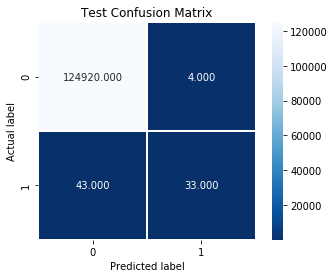

In [28]:
# Confusion Matrix for "Threat"
cm = metrics.confusion_matrix(Y_test['threat'], results['threat'])
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Test Confusion Matrix");

* Notice that most errors are false negatives for "threat". False positives are very rare.
* Given our context, FNs are not as detrimental as FPs. We would rather have a threatening player roam free to get caught in their next game instead of having an innocent player punished. In addition, report systems are always in place in high toxicity-inducing games, so the threatening player would get reported and get reviewed even closer.